# Блок 1

#### Воспользовавшись [данными Spotify](https://www.kaggle.com/datasets/rodolfofigueroa/spotify-12m-songs/code) и удобными для вас библиотеками для рисования/обработки датафреймов ответьте на список вопросов, аргументировав свою позицию.

In [1]:
import polars as pl
import pandas as pd
import polars.selectors as sc
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import ast
sns.set_theme('paper')
sns.set_style('darkgrid')

In [2]:
tracks = pl.read_csv('tracks_features.csv')
nuq_shape = tracks.shape

In [3]:
tracks.columns

['id',
 'name',
 'album',
 'album_id',
 'artists',
 'artist_ids',
 'track_number',
 'disc_number',
 'explicit',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms',
 'time_signature',
 'year',
 'release_date']

### 1) Можно ли по данным датасета спотифай сказать, что музыкальные композиции с 90х годов стали сложнее или проще?

Для начала удалим все что вероятнее всего не оказывает никакого прямого влияния на описание музыкальных композицийт не будет использованно, а так же удалим повторяющиеся записи и данные с пропусками если они есть. Так же разделим данные на треки после 90x и более ранние.

In [4]:
useless_cols = ['name',
    'album',
    'album_id',
    'artists',
    'artist_ids',
    'track_number',
    'disc_number',
    'release_date',
 ]
tracks = tracks.select(pl.col('*').exclude(useless_cols)).unique(pl.col('id')).drop_nulls()
uq_shape = tracks.shape
uq_shape[0] == nuq_shape[0]

True

In [5]:
tracks_old = tracks.filter(pl.col('year') < 1990).select(pl.all().exclude(['year', 'id']))
tracks_new = tracks.filter(pl.col('year') >= 1990).select(pl.all().exclude(['year', 'id']))
len(tracks_old), len(tracks_new)

(59408, 1144617)

In [6]:
tracks.filter(pl.col('year') < 1900).count()

id,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10


Скорее всего 10 треков за слишком ранний период это выбросы, не будем брать их к ассмотрению

In [7]:
tracks = tracks.filter(pl.col('year') > 1900)

Моя гипотеза состоит в том, что, сложность музыки можно оценить по таким критериям как громкость, "пригодность для танцев" - со всеми вытекающими ввиде тональности ('mode'), преобладания позитивного настроя ('valence'), меры интенсивности ('energy'), соотношения показателей речи и "музыкальности" ('speechiness', 'instrumentalness') трека.

В данном контексте под сложностью музыки мной понимается то, что, чем более сложной является музыка, тем менее она подходит под стандартный танцевальный формат.

Посмотрим на описательные статистики характеристик треков за последние 30 лет и более ранние

In [8]:
tracks_new.select(sc.numeric().exclude('mode')).describe()

statistic,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1.144617e6,1.144617e6,1.144617e6,1.144617e6,1.144617e6,1.144617e6,1.144617e6,1.144617e6,1.144617e6,1.144617e6,1.144617e6,1.144617e6
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.49414,0.513601,5.198438,-11.683434,0.085285,0.44119,0.284774,0.200649,0.425137,117.720612,248752.03535,3.833053
"""std""",0.190034,0.294986,3.538527,6.994098,0.116761,0.385354,0.377054,0.178987,0.269365,30.965759,162365.808575,0.561448
"""min""",0.0,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0
"""25%""",0.357,0.257,2.0,-15.043,0.0352,0.0343,0.000007,0.0969,0.19,94.093,174500.0,4.0
"""50%""",0.502,0.53,5.0,-9.6,0.0447,0.374,0.00849,0.125,0.4,116.894,224640.0,4.0
"""75%""",0.634,0.771,8.0,-6.62,0.0733,0.857,0.724,0.244,0.64,137.226,285920.0,4.0
"""max""",1.0,1.0,11.0,7.234,0.969,0.996,1.0,1.0,1.0,248.934,6.06109e6,5.0


In [9]:
tracks_new.select(~sc.numeric(), pl.col('mode')).describe()

statistic,explicit,mode
str,f64,f64
"""count""",1.144617e6,1.144617e6
"""null_count""",0.0,0.0
"""mean""",0.071895,0.668363
"""std""",null,0.470801
"""min""",0.0,0.0
"""25%""",null,0.0
"""50%""",null,1.0
"""75%""",null,1.0
"""max""",1.0,1.0


In [10]:
tracks_old.select(sc.numeric().exclude('mode')).describe()

statistic,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",59408.0,59408.0,59408.0,59408.0,59408.0,59408.0,59408.0,59408.0,59408.0,59408.0,59408.0,59408.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.472187,0.431224,5.111567,-14.222271,0.066994,0.553901,0.245985,0.219918,0.48289,115.97237,250532.001565,3.821724
"""std""",0.181246,0.277407,3.500944,6.27701,0.09842,0.36611,0.359154,0.205936,0.285729,30.330943,159177.513668,0.55594
"""min""",0.0,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0,0.0,1254.0,0.0
"""25%""",0.338,0.191,2.0,-17.614,0.0344,0.17,0.0000105,0.0945,0.228,93.063,167707.0,4.0
"""50%""",0.478,0.401,5.0,-13.1,0.0419,0.639,0.0037,0.133,0.484,114.714,217613.0,4.0
"""75%""",0.607,0.658,8.0,-9.753,0.058,0.917,0.56,0.273,0.729,134.672,284267.0,4.0
"""max""",0.987,1.0,11.0,3.744,0.962,0.996,1.0,1.0,1.0,243.507,3.736734e6,5.0


In [11]:
tracks_old.select(~sc.numeric(), pl.col('mode')).describe()

statistic,explicit,mode
str,f64,f64
"""count""",59408.0,59408.0
"""null_count""",0.0,0.0
"""mean""",0.005992,0.731114
"""std""",null,0.443384
"""min""",0.0,0.0
"""25%""",null,0.0
"""50%""",null,1.0
"""75%""",null,1.0
"""max""",1.0,1.0


Что бы оценить поведение характеристик в течение времени визуализируем описанные выше показатели отвечающие за предполагаемую сложность музыки, для лучшей инфографики разобъем все треки по принадлежности к 10 летним промежуткам и на основе этого будем рассчитывать интересующие показатели, для лучшего понимания временной структуры данных.

Заметка: основной статистикой для анализа будет выступать среднее, так как данные отнормированны и не содержат выбросов => статистика не должна иметь сильное смещение

In [12]:
tracks = tracks.with_columns(((pl.col('year') - 1900) // 10 * 10 + 1900).alias('decade'))

In [13]:
mode_agg = tracks.select(
        pl.col(['decade', 'mode'])
    ).group_by(
        ('decade', 'mode'), maintain_order=True
    ).agg(pl.col('mode').count().log10().alias('cnt'))

energy_valence_agg = tracks.select(
        pl.col(['decade', 'energy', 'valence'])
    ).group_by(
        'decade', maintain_order=True
    ).agg(pl.all().mean()).unpivot(
        index='decade', variable_name='type', value_name='mean'
    )

speechiness_instrumentalness_agg = tracks.select(
        pl.col(['decade', 'instrumentalness', 'speechiness'])
    ).group_by(
        'decade', maintain_order=True
    ).agg(pl.all().mean()).unpivot(
        index='decade', variable_name='type', value_name='mean'
    )

dancebility_agg = tracks.select(
        pl.col(['decade', 'danceability'])
    ).group_by(
        'decade', maintain_order=True
    ).agg(pl.col('danceability').mean().alias('mean'))

Text(0.5, 1.0, 'Распределение среднего пригодности для танцев')

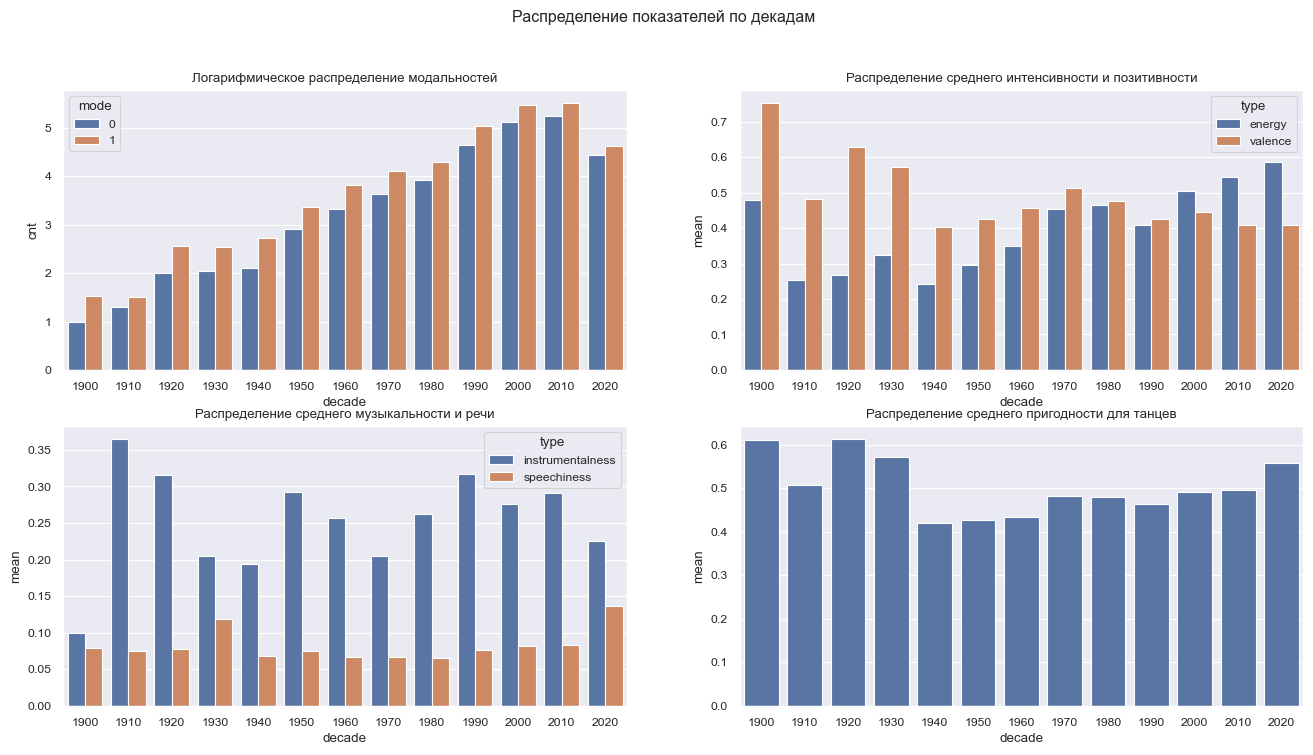

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
fig.suptitle('Распределение показателей по декадам')

sns.barplot(mode_agg, ax=axes[0, 0], x='decade', y='cnt', hue='mode').set_title('Логарифмическое распределение модальностей')
sns.barplot(energy_valence_agg, ax=axes[0, 1], x='decade', y='mean', hue='type').set_title('Распределение среднего интенсивности и позитивности')
sns.barplot(speechiness_instrumentalness_agg, ax=axes[1, 0], x='decade', y='mean', hue='type').set_title('Распределение среднего музыкальности и речи')
sns.barplot(dancebility_agg, ax=axes[1, 1], x='decade', y='mean').set_title('Распределение среднего пригодности для танцев')

Из рассмотренных, распределенных по временной шкале статистик можно сделать визуальные выводы, что:
1) В целом показатель модальностей (мажор/минор) сохраняют свои соотношения.
2) Видно что с течением времени нарастает интенсивность и активность музыки, при этом можно наблюдать снижение позитивности ~ как в 1940-х
3) Поведение колличества речи и инструментального наполнения имеет периодический характер и являются антагонистами (увеличение одного, влияет на снижение другого)
4) Показатель пригодности для танцев находится на меньшем значении, чем в начале 1900, но заметна тенденция к возрастанию данного параметра с 1940-х годов, однако вероятно высокие показатели для 1900-1930 годов можно объяснить тем, что в этом промежутке находится довольно малая часть выборки, которая не является репрезентативной для данного периода.

<Axes: >

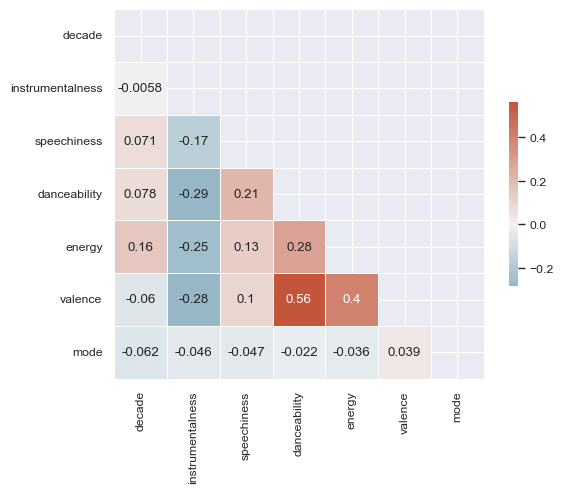

In [15]:
corr = tracks.select(pl.col(['decade', 'instrumentalness', 'speechiness', 'danceability', 'energy', 'valence', 'mode'])).corr()
corr_mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=corr_mask, center=0, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, xticklabels=corr.columns, yticklabels=corr.columns)

Однако рассматривая кореляцию признаков с периодом, можно видеть что какой-либо сильной линейной взаимосвязи между временным периодом и признаками нет.

**Вывод:** По наблюдаемым данным относительно поставленных критериев сложно говорить о значительном увеличении или снижении сложности музыки. Однако можно все-равно заметить небольшой рост показателей танцевальности и активности музыки, что может говорить о некотором снижении сложности.

### 3) (valence - Measures how positive a track sounds, from 1 to 0) - как коррелирует с характером(мажор/минор) тональности и коррелирует ли

Для начала посмотрим что из себя представляют распределения значений этих переменных и их колличество.

In [16]:
tracks.select(pl.col('valence')).n_unique(), tracks.select(pl.col('mode')).n_unique()

(1884, 2)

<Axes: ylabel='Count'>

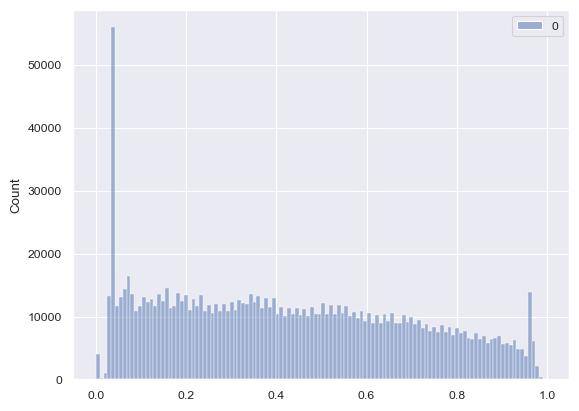

In [17]:
sns.histplot(tracks.select(pl.col('valence')))

Понятно что mode - номинальная переменная, valence - семпл  из каого-то непрерывного распределения, но очевидно ограниченного на отрезке [0, 1].

Для оценки кореляции между переменными воспользуемся Point-biserial correlation coefficient, т.к он как раз предназначен для оценки кореляции между бинарной номинативной переменной Y и непрерывной X.

In [18]:
def pb_corr(df, cont, nom, nom_values=[0, 1]):
    df_len = len(df)
    df_split_1 = df.filter(pl.col(nom) == nom_values[0]).select(pl.col([cont, nom]))
    df_split_2 = df.filter(pl.col(nom) == nom_values[1]).select(pl.col([cont, nom]))
    corr = (df_split_2.select(pl.col(cont)).mean() - df_split_1.select(pl.col(cont)).mean())
    return corr * (len(df_split_1) * len(df_split_2) / (df_len * (df_len - 1))) ** (1 / 2) / df.select(pl.col(cont)).std()


In [19]:
pb_corr(tracks, 'valence', 'mode')

valence
f64
0.039036


Из полученного коэффициента кореляции можно сделать вывод о слабой линейной зависимости между переменными.

### 2) Коррелирует ли характер тональности с темпом

Посмотрим на распределение переменной tempo, предположительно оно похоже на нормальную величину, оценим это предположение визуально с помошью qq-plot

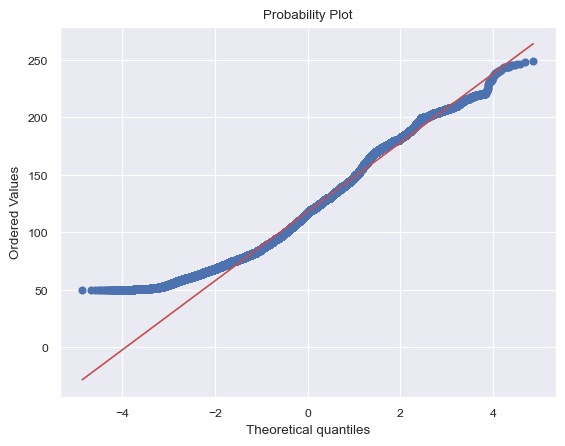

In [20]:
import scipy.stats as stats
tracks = tracks.filter(pl.col('tempo') >= 50)
stats.probplot(tracks.select(pl.col('tempo')).to_numpy().flatten(), plot=plt)
pass

Для оценки кореляции между семплом из непрерывного распределения и тональностью, являющуюся категориальной переменной применим кореляцию спирмена.

In [21]:
tracks.select(pl.corr('tempo', 'key', method='spearman'))

tempo
f64
0.004737


По полученному показателю можно судить о почти полном отсутствии линейной зависимости между переменными

### 4) Можно ли сказать, что за последнее время ключи тональностей (key) стали менее/более разнообразным

In [22]:
key_count = tracks.group_by(['decade', 'key']).agg(pl.count())
decade_groups = key_count.pivot('decade', index='key')
decade_groups = decade_groups.with_columns([((pl.col(col)/ pl.col(col).sum())) for col in decade_groups.columns if col != 'key'])
long_data = decade_groups.melt(id_vars='key', variable_name="year", value_name="value")

/var/folders/tk/yyvw73cn5pb00ymf5kkn6gn80000gn/T/ipykernel_75567/34961785.py:1: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  key_count = tracks.group_by(['decade', 'key']).agg(pl.count())
/var/folders/tk/yyvw73cn5pb00ymf5kkn6gn80000gn/T/ipykernel_75567/34961785.py:4: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  long_data = decade_groups.melt(id_vars='key', variable_name="year", value_name="value")


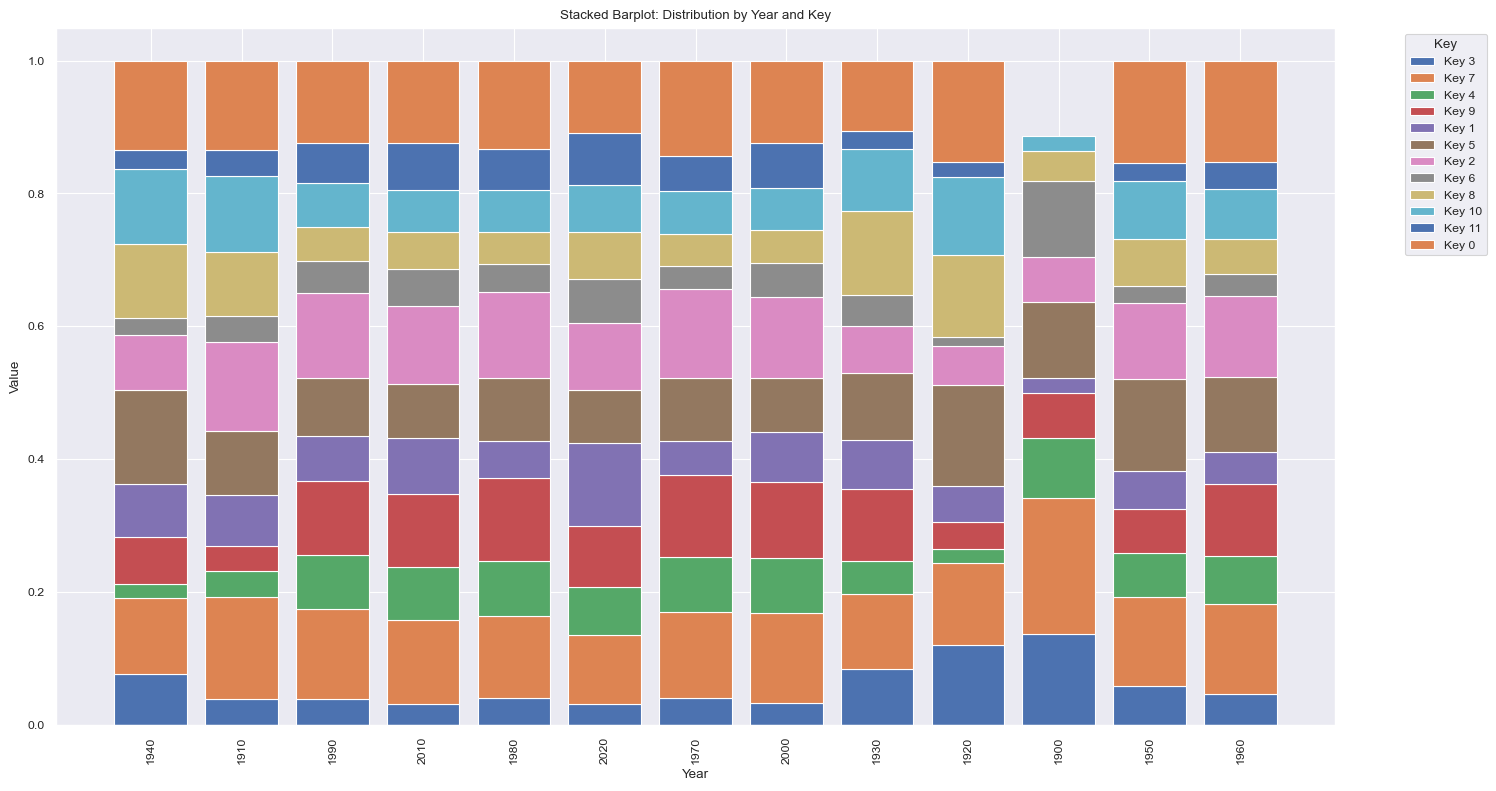

In [23]:
df = long_data.to_pandas()

# Шаг 2: Подготовка данных для построения stacked barplot
keys = df['key'].unique()  # Уникальные ключи (категории)
years = df['year'].unique()  # Уникальные годы
values = np.zeros((len(keys), len(years)))  # Массив для значений

# Заполняем массив значениями
for i, key in enumerate(keys):
    values[i] = df[df['key'] == key]['value'].values

# Шаг 3: Построение stacked barplot
fig, ax = plt.subplots(figsize=(15, 8))

# Создаем stacked barplot
bottom = np.zeros(len(years))  # Начальные нули для "подошвы" столбиков
for i, key in enumerate(keys):
    ax.bar(years, values[i], bottom=bottom, label=f'Key {key}')
    bottom += values[i]  # Обновляем нижнюю границу для следующего слоя

# Шаг 4: Настройка графика
plt.xticks(rotation=90)
plt.title('Stacked Barplot: Distribution by Year and Key')
plt.ylabel('Value')
plt.xlabel('Year')
plt.legend(title="Key", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Показываем график
plt.show()

Как можно увидеть из распределения отнормированных величин ключи тональностей остались примерно на том же уровне

заметка: пофиксить порядок лет

### 5) Какое совместное влияние оказывают факторы tempo, mode и loudness на показатель valence

Для оценки совместного влияния воспользуемся линейной регрессией, т.к она отражает линейное влияние предикторов на предсказываемую переменную.

In [24]:
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
X = tracks.select(pl.col(['tempo', 'mode', 'loudness'])).to_numpy()
y = tracks.select(pl.col('valence')).to_numpy()
model = linear_model.Ridge().fit(X, y)
predict = model.predict(X)
r2_score(y, predict), mean_squared_error(y, predict)

(0.15425448479926185, np.float64(0.06165176705125182))

In [25]:
model.coef_

array([[0.00068837, 0.02203216, 0.01423397]])

В качестве результата можно заключить, что линейная модель плохо приближает целевую переменную такой комбинацией признаков.

# Блок 2

#### Воспользовавшись данными с сайта о продаже музыкальных инструментов и удобными для вас библиотеками для рисования/обработки датафреймов ответьте на список вопросов, аргументировав свою позицию.

### 1) Какие факторы влияют на цену инструмента и как?

In [26]:
df = pd.read_csv("reverb_aggregated.csv") 
df['param_dict'] = df['param_dict'].apply(ast.literal_eval)
parsed_df = pd.json_normalize(df['param_dict'])
df = df.drop('param_dict', axis=1).join(parsed_df)
df.columns

Index(['title', 'description', 'text', 'price', 'listing_id', 'Condition',
       'Brand', 'Model', 'Categories', 'Year', 'Fretboard Material',
       'Pickup Configuration', 'Color Family', 'Right / Left Handed',
       'Body Shape', 'Number of Strings', 'Fretboard Radius', 'Neck Material',
       'Offset Body', 'Finish Style', 'Body Type', 'Body Material', 'Series',
       'Bridge/Tailpiece Type', 'Wood Top Style', 'Nut Width', 'Model Family',
       'Scale Length', 'Neck Construction', 'Number of Frets', 'Made In',
       'Finish', 'Product Family', 'Artist', 'Frets', 'Top Material',
       'Finish Features', 'Model Sub-Family'],
      dtype='object')

In [27]:
df.head()

,title,description,text,price,listing_id,Condition,Brand,Model,Categories,Year,...,Neck Construction,Number of Frets,Made In,Finish,Product Family,Artist,Frets,Top Material,Finish Features,Model Sub-Family
0,Fender American Standard Stratocaster [XIX19] ...,Welcome to Qsic's Reverb Shop!1. The descripti...,Welcome to Qsic's Reverb Shop!1. The descripti...,"$1,131.92",cbbfd652-ca5f-11ed-8644-acde48001122,Very Good (Used)Very Good items may show a few...,Fender,American Standard Stratocaster with Rosewood F...,Solid Body,2008,...,Bolt-On,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Fender ""American Vintage II 1951 Telecaster"" 3...",The Fender® American Vintage II series present...,The Fender® American Vintage II series present...,"$1,935.55",cd998c16-ca5f-11ed-8644-acde48001122,Brand New (New)Brand New items are sold by an ...,Fender,"""American Vintage II 1951 Telecaster"" HARDCASE...",NaN,NaN,...,NaN,NaN,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Rebel Custom Guitars Funky Claude 2022 - Hydro...,Stratocaster Style Custom Guitar by Rebel Cust...,Stratocaster Style Custom Guitar by Rebel Cust...,"$1,055.53",cfe6936a-ca5f-11ed-8644-acde48001122,Brand New (New)Brand New items are sold by an ...,Rebel Custom Guitars,Funky Claude,Solid Body,2022,...,NaN,NaN,Australia,"Hydro Graphic Film, 2k Clear Coat, Natural Nec...",NaN,NaN,NaN,NaN,NaN,NaN
3,Fender AMERICAN PROFESSIONAL Stratocaster [MJ8...,Welcome to Qsic's Reverb Shop!1. The descripti...,Welcome to Qsic's Reverb Shop!1. The descripti...,"$1,290.62",d1e90396-ca5f-11ed-8644-acde48001122,Very Good (Used)Very Good items may show a few...,Fender,American Professional Stratocaster with Rosewo...,Solid Body,2017,...,Bolt-On,22,NaN,NaN,Fender Stratocaster,NaN,NaN,NaN,NaN,NaN
4,G&L S-500 Premium C.F.S [MJ724] | Reverb,Welcome to Qsic's Reverb Shop!1. The descripti...,Welcome to Qsic's Reverb Shop!1. The descripti...,$575.55,d3f30786-ca5f-11ed-8644-acde48001122,Very Good (Used)Very Good items may show a few...,G&L,S-500 Premium C.F.S [MJ724],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разумно перевести цены в числовой эквивалент

In [28]:
df['price'] = df['price'].apply(lambda x: float(x.translate(x.maketrans({'$': '', ',': ''}))))

Посмотрим на размер данных и наличие пропусков

In [29]:
len(df), df.isnull().sum()

(31920,
 title                        0
 description                  0
 text                         0
 price                        0
 listing_id                   0
 Condition                    0
 Brand                        0
 Model                        0
 Categories                7929
 Year                     12890
 Fretboard Material       20019
 Pickup Configuration     20572
 Color Family             24396
 Right / Left Handed      12991
 Body Shape               15780
 Number of Strings        16802
 Fretboard Radius         26706
 Neck Material            21050
 Offset Body              23532
 Finish Style             23089
 Body Type                16729
 Body Material            21951
 Series                   25951
 Bridge/Tailpiece Type    21829
 Wood Top Style           25697
 Nut Width                27982
 Model Family             23964
 Scale Length             22357
 Neck Construction        22544
 Number of Frets          23121
 Made In                  12018


Есть много пропусков но в данном анализе пропустим их так как они не будут нам мешать

Цена гитары формируется в основном в зависимости от ее модели, состояния  и бренда.

Посмотрим на возможные состояния гитар.

In [30]:
df['Condition'].unique()

array(['Very Good (Used)Very Good items may show a few slight marks or scratches but are fully functional and in overall great shape.learn more',
       'Brand New (New)Brand New items are sold by an authorized dealer or original builder and include all original packaging.learn more',
       'Good (Used)Good condition items function properly but may exhibit some wear and tear.learn more',
       'Excellent (Used)Excellent items are almost entirely free from blemishes and other visual defects and have been played or used with the utmost care.learn more',
       'Mint (Used)Mint items are in essentially new original condition but have been opened or played.learn more',
       'Fair (Used)Fair condition gear should function but will show noticeable cosmetic damage or other issues.learn more',
       'Non Functioning (Used)Non-functioning items do not work as they should. All known issues should be described in the listing description.learn more',
       'Poor (Used)Poor condition gear may

Посмотрим на описательные статистики связанные с состоянием инструментов.

In [31]:
df.groupby("Condition")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
Condition,,,,,,,,
"B-Stock (Used)B-Stock items are sold by an authorized dealer or original builder, but have been opened, blemished, or used in some manner.learn more",122.0,1241.156803,786.417844,209.30,634.7425,1191.76,1500.0000,4336.06
Brand New (New)Brand New items are sold by an authorized dealer or original builder and include all original packaging.learn more,12356.0,1949.631789,2013.969559,2.00,642.8925,1298.30,2647.7500,33333.00
Excellent (Used)Excellent items are almost entirely free from blemishes and other visual defects and have been played or used with the utmost care.learn more,6538.0,3347.440211,5244.340276,31.61,1000.0000,2000.00,3903.3600,101200.00
Fair (Used)Fair condition gear should function but will show noticeable cosmetic damage or other issues.learn more,322.0,2122.739348,9718.738376,4.00,341.7900,617.00,1534.9675,149995.00
Good (Used)Good condition items function properly but may exhibit some wear and tear.learn more,2696.0,2081.742359,4156.339237,6.00,607.0000,1100.00,2168.2975,95000.00
Mint (Used)Mint items are in essentially new original condition but have been opened or played.learn more,3117.0,3904.651136,12277.475915,6.00,935.0000,1955.32,4100.0000,387363.74
Non Functioning (Used)Non-functioning items do not work as they should. All known issues should be described in the listing description.learn more,32.0,705.770313,1228.593664,55.00,135.0000,295.00,899.9900,6995.00
Poor (Used)Poor condition gear may not work properly but can still perform most functions.learn more,34.0,1040.601471,1802.289271,149.00,237.4750,682.00,899.0000,8000.00
Very Good (Used)Very Good items may show a few slight marks or scratches but are fully functional and in overall great shape.learn more,6703.0,2745.495477,5060.929667,28.62,799.0000,1462.50,3055.6900,139995.00


Для большей наглядности провизуализируем распределение цен на гитары по категориям состояния, и посмотрим на общее распределение гитар на рынке

Text(0.5, 0, 'Цена')

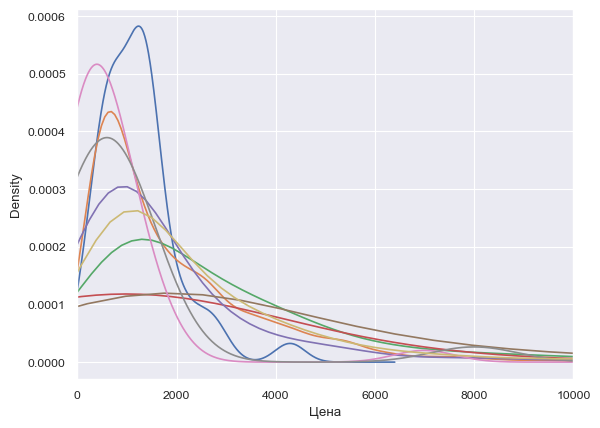

In [32]:
quality_sorted = ['Non Functioning', 'Poor', 'B-Stock', 'Fair', 
'Good', 'Very Good', 'Excellent', 'Mint', 'Brand New']
df['Condition'] = df['Condition'].apply(lambda x: x[0:x.find("(")].rstrip())
df.groupby("Condition")["price"].plot(kind = "kde", xlim= [0, 10000])

plt.xlabel('Цена')

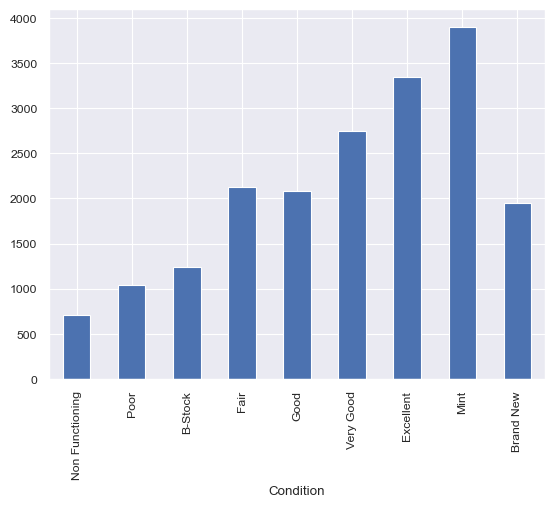

In [33]:
price_new = df.groupby("Condition")["price"].mean().reindex(quality_sorted).plot(kind = "bar")

Вывод: можно заключить, что цена на инструменты значительно зависит от состояния (почти линейно), но это так-же можно объяснить тем, что цены на многие инструменты зависят не только от состояния но и от раритетности (возраста) инструмента. Так многие инструменты имеющие невысокую стартовую цену с течением времени по тем или иным причинам подвергаются значительному увеличению цен. Так же вероятнее всего инструменты с состоянием как новое это какие-то дорогие модели приобретенные в целях коллекционирования.